2025-10-08 15:42:01,571 - INFO - Iteration 1/50, Max site change: 1.298245
2025-10-08 15:42:01,575 - INFO - Iteration 2/50, Max site change: 1.120474
2025-10-08 15:42:01,579 - INFO - Iteration 3/50, Max site change: 0.985434
2025-10-08 15:42:01,583 - INFO - Iteration 4/50, Max site change: 0.877821
2025-10-08 15:42:01,587 - INFO - Iteration 5/50, Max site change: 0.785859
2025-10-08 15:42:01,592 - INFO - Iteration 6/50, Max site change: 0.705244
2025-10-08 15:42:01,600 - INFO - Iteration 7/50, Max site change: 0.633773
2025-10-08 15:42:01,612 - INFO - Iteration 8/50, Max site change: 0.570042
2025-10-08 15:42:01,623 - INFO - Iteration 9/50, Max site change: 0.513026
2025-10-08 15:42:01,639 - INFO - Iteration 10/50, Max site change: 0.461913
2025-10-08 15:42:01,644 - INFO - Iteration 11/50, Max site change: 0.417231
2025-10-08 15:42:01,662 - INFO - Iteration 12/50, Max site change: 0.379217
2025-10-08 15:42:01,667 - INFO - Iteration 13/50, Max site change: 0.344934
2025-10-08 15:42:01,6

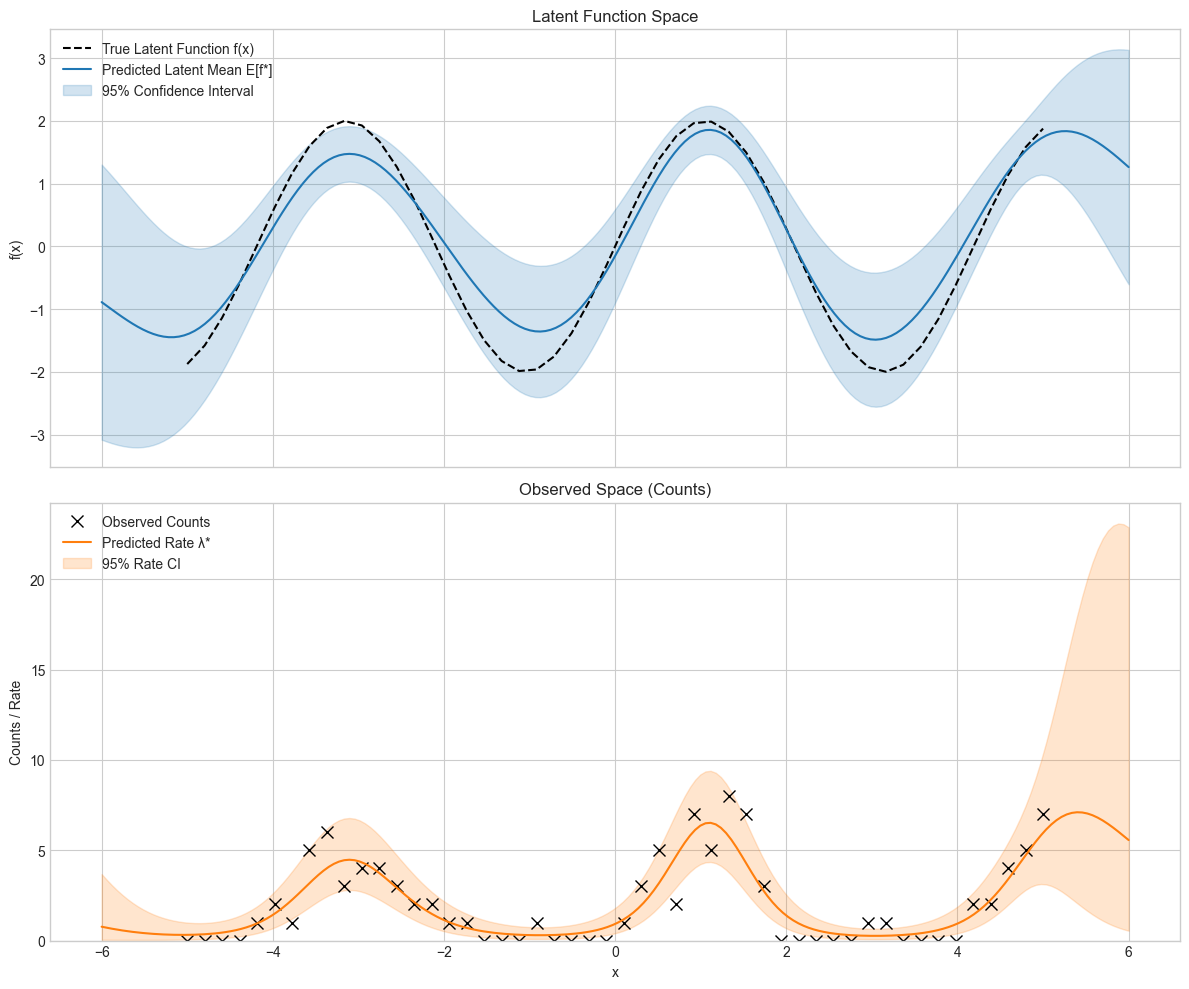

In [1]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Fixed Hyperparameters ---
# You can adjust these to see how they affect the model's performance
LENGTHSCALE = 1.0
VARIANCE = 1.5
JITTER = 1e-6 # Small value for numerical stability

class GP_EP_Poisson:
    """
    Gaussian Process with Poisson Likelihood using Expectation Propagation (EP).
    
    This implementation uses a Gaussian-Hermite quadrature for moment matching,
    which is necessary because the Poisson likelihood is not conjugate to the
    Gaussian prior.
    """
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.K = None
        self.K_inv = None
        
        # Posterior and site parameters that will be learned by EP
        self.post_mean = None
        self.post_cov = None
        self.site_tau = None # Site precisions t_i = 1/sigma_i^2
        self.site_nu = None  # Site mean*precision t_i * mu_i
        
        # Quadrature nodes and weights for numerical integration
        nodes, weights = np.polynomial.hermite.hermgauss(100)
        self.quad_nodes = torch.tensor(nodes, dtype=torch.float64)
        self.quad_weights = torch.tensor(weights, dtype=torch.float64)

    def _rbf_kernel(self, X1, X2, lengthscale, variance):
        """Radial Basis Function (RBF) kernel."""
        sq_dist = torch.cdist(X1, X2, p=2).pow(2)
        return variance * torch.exp(-0.5 * sq_dist / lengthscale**2)

    def _moment_match_poisson(self, y_i, cavity_mean, cavity_var):
        """
        Performs moment matching for the tilted distribution using quadrature.
        
        The tilted distribution is q(f_i) * p(y_i|f_i), where q is the cavity
        and p is the Poisson likelihood. We want to find a Gaussian that
        best approximates this tilted distribution by matching its first two moments.
        """
        # Transform quadrature nodes to the cavity distribution's scale
        f_nodes = cavity_mean + torch.sqrt(2 * cavity_var) * self.quad_nodes
        
        # Evaluate the log-likelihood at each node
        # log p(y|f) = y*f - exp(f) - log(y!)
        # We can ignore the log(y!) term as it's constant w.r.t f
        log_likelihood_vals = y_i * f_nodes - torch.exp(f_nodes)
        
        # Use log-sum-exp for numerical stability
        log_weights_plus_ll = torch.log(self.quad_weights / math.sqrt(math.pi)) + log_likelihood_vals
        log_Z = torch.logsumexp(log_weights_plus_ll, dim=0)
        
        # Normalized weights for moment calculation
        norm_weights = torch.exp(log_weights_plus_ll - log_Z)
        
        # Calculate mean and variance of the new (tilted) distribution
        new_mean = torch.sum(norm_weights * f_nodes)
        new_var = torch.sum(norm_weights * (f_nodes - new_mean)**2)
        
        return new_mean, new_var

    def fit(self, X, y, max_iter=50, tol=1e-5, damping=0.9):
        """
        Fits the GP model using the EP algorithm.
        """
        self.X_train = X.double()
        self.y_train = y.double()
        N = len(X)
        
        # --- 1. Initialization ---
        self.K = self._rbf_kernel(self.X_train, self.X_train, LENGTHSCALE, VARIANCE) + \
                 torch.eye(N, dtype=torch.float64) * JITTER
        self.K_inv = torch.inverse(self.K)
        
        # Initialize site parameters to be non-informative (zeros)
        self.site_tau = torch.zeros(N, dtype=torch.float64)
        self.site_nu = torch.zeros(N, dtype=torch.float64)
        
        # Initialize posterior as the prior
        self.post_cov = self.K.clone()
        self.post_mean = torch.zeros(N, dtype=torch.float64)
        
        # --- 2. EP Iterations ---
        for i in range(max_iter):
            prev_site_params = torch.cat((self.site_tau, self.site_nu))
            
            # Iterate through each data point
            for j in range(N):
                # --- a. Compute Cavity Distribution ---
                # Remove site j's contribution from the posterior
                post_prec_j = 1.0 / self.post_cov[j, j]
                cavity_prec_j = post_prec_j - self.site_tau[j]
                
                # Check for numerical issues
                if cavity_prec_j < 1e-8:
                    cavity_prec_j = 1e-8 # Clamp to avoid division by zero
                
                cavity_var_j = 1.0 / cavity_prec_j
                cavity_mean_j = cavity_var_j * (self.post_mean[j] * post_prec_j - self.site_nu[j])
                
                # --- b. Moment Matching ---
                # Find moments of the Gaussian that best fits the tilted distribution
                new_post_mean_j, new_post_var_j = self._moment_match_poisson(
                    self.y_train[j], cavity_mean_j, cavity_var_j
                )

                # --- c. Update Site Parameters ---
                new_site_prec_j = 1.0 / new_post_var_j - cavity_prec_j
                
                # Clamp for stability
                if new_site_prec_j < 1e-8:
                    new_site_prec_j = 1e-8
                
                new_site_nu_j = new_post_mean_j / new_post_var_j - cavity_mean_j / cavity_var_j
                
                # Use damping for more stable convergence
                self.site_tau[j] = damping * self.site_tau[j] + (1 - damping) * new_site_prec_j
                self.site_nu[j] = damping * self.site_nu[j] + (1 - damping) * new_site_nu_j

            # --- d. Update Full Posterior ---
            # Recompute posterior mean and covariance from all updated site parameters.
            # This is O(N^3) but simpler to implement than rank-1 updates.
            site_prec_sqrt = torch.sqrt(self.site_tau)
            L = torch.linalg.cholesky(torch.eye(N, dtype=torch.float64) + \
                 site_prec_sqrt.unsqueeze(1) * self.K * site_prec_sqrt)
            V = torch.linalg.solve(L, site_prec_sqrt.unsqueeze(1) * self.K)
            self.post_cov = self.K - V.T @ V
            self.post_mean = self.post_cov @ self.site_nu
            
            # --- e. Check for Convergence ---
            current_site_params = torch.cat((self.site_tau, self.site_nu))
            delta = torch.max(torch.abs(current_site_params - prev_site_params))
            logging.info(f"Iteration {i+1}/{max_iter}, Max site change: {delta.item():.6f}")
            if delta < tol:
                logging.info(f"Converged after {i+1} iterations.")
                break
        
        if i == max_iter - 1:
            logging.warning("EP did not converge within the maximum number of iterations.")

    def predict(self, X_star):
        """
        Make predictions for new data points X_star.
        """
        if self.X_train is None:
            raise RuntimeError("Model has not been trained yet. Call fit() first.")
        
        X_star = X_star.double()
        K_star = self._rbf_kernel(self.X_train, X_star, LENGTHSCALE, VARIANCE)
        K_star_star = self._rbf_kernel(X_star, X_star, LENGTHSCALE, VARIANCE)
        
        # --- Predictive Mean and Variance of the Latent Function f* ---
        # E[f*] = K*^T K^-1 mu
        # Var[f*] = K** - K*^T K^-1 K* + K*^T K^-1 Sigma K^-1 K*
        pred_mean_f = K_star.T @ self.K_inv @ self.post_mean
        
        v = torch.linalg.solve(self.K, K_star)
        pred_var_f = torch.diag(K_star_star) - torch.sum(v * K_star, dim=0) + \
                     torch.sum(v * (self.post_cov @ v), dim=0)
        
        # --- Predictive Rate (lambda*) ---
        # For a log-link E[lambda*] = E[exp(f*)] = exp(mu_f* + 0.5 * var_f*)
        pred_rate = torch.exp(pred_mean_f + 0.5 * pred_var_f)
        
        return pred_mean_f, pred_var_f, pred_rate

# --- Main execution block ---
if __name__ == '__main__':
    # --- 1. Generate Synthetic Data ---
    torch.manual_seed(42)
    N_train = 50
    X_train = torch.linspace(-5, 5, N_train).unsqueeze(1)
    
    # A latent function
    f_true = 2 * torch.sin(X_train * 1.5).squeeze()
    
    # Generate observed counts from a Poisson distribution
    # The rate lambda is determined by the latent function via a log-link
    lambda_true = torch.exp(f_true)
    y_train = torch.poisson(lambda_true)
    
    # --- 2. Instantiate and Fit the Model ---
    gp_model = GP_EP_Poisson()
    gp_model.fit(X_train, y_train)
    
    # --- 3. Predict on a Grid of Points ---
    X_test = torch.linspace(-6, 6, 200).unsqueeze(1)
    pred_mean_f, pred_var_f, pred_rate = gp_model.predict(X_test)
    
    # Convert to numpy for plotting
    pred_mean_f = pred_mean_f.detach().numpy()
    pred_std_f = torch.sqrt(pred_var_f).detach().numpy()
    pred_rate = pred_rate.detach().numpy()
    
    # --- 4. Plot Results ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Latent function space
    ax1.plot(X_train.numpy(), f_true.numpy(), 'k--', label='True Latent Function f(x)')
    ax1.plot(X_test.numpy(), pred_mean_f, color='C0', label='Predicted Latent Mean E[f*]')
    ax1.fill_between(X_test.squeeze().numpy(), 
                     pred_mean_f - 1.96 * pred_std_f,
                     pred_mean_f + 1.96 * pred_std_f, 
                     color='C0', alpha=0.2, label='95% Confidence Interval')
    ax1.set_title('Latent Function Space')
    ax1.set_ylabel('f(x)')
    ax1.legend()
    
    # Plot 2: Observed data space (counts)
    ax2.plot(X_train.numpy(), y_train.numpy(), 'kx', markersize=8, label='Observed Counts')
    ax2.plot(X_test.numpy(), pred_rate, color='C1', label='Predicted Rate λ*')
    
    # Compute rate uncertainty (optional, requires sampling or approximation)
    rate_upper = torch.exp(torch.tensor(pred_mean_f) + 1.96 * torch.tensor(pred_std_f)).numpy()
    rate_lower = torch.exp(torch.tensor(pred_mean_f) - 1.96 * torch.tensor(pred_std_f)).numpy()
    ax2.fill_between(X_test.squeeze().numpy(), rate_lower, rate_upper, 
                     color='C1', alpha=0.2, label='95% Rate CI')

    ax2.set_title('Observed Space (Counts)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Counts / Rate')
    ax2.set_ylim(bottom=0)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [12]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')


class GP_EP_Poisson(torch.nn.Module):
    def __init__(self, initial_lengthscale=1.0, initial_variance=1.5):
        super().__init__()
        self.log_lengthscale = torch.nn.Parameter(
            torch.tensor(math.log(initial_lengthscale), dtype=torch.float64)
        )
        self.log_variance = torch.nn.Parameter(
            torch.tensor(math.log(initial_variance), dtype=torch.float64)
        )
        
        self.X_train = None
        self.y_train = None
        self.K = None
        self.K_inv = None
        
        self.post_mean = None
        self.post_cov = None
        self.site_tau = None
        self.site_nu = None
        
        nodes, weights = np.polynomial.hermite.hermgauss(100)
        self.quad_nodes = torch.tensor(nodes, dtype=torch.float64)
        self.quad_weights = torch.tensor(weights, dtype=torch.float64)

        self.cavity_mean_memo = None
        self.cavity_var_memo = None
        self.log_Z_memo = None

    def _rbf_kernel(self, X1, X2, lengthscale, variance):
        sq_dist = torch.cdist(X1, X2, p=2).pow(2)
        return variance * torch.exp(-0.5 * sq_dist / lengthscale**2)

    # MODIFIED: Corrected redundant torch.tensor call
    def _moment_match_poisson(self, y_i, cavity_mean, cavity_var):
        # FIX: cavity_var is already a tensor, no need to re-wrap it.
        # Re-wrapping can detach it from the computation graph.
        f_nodes = cavity_mean + torch.sqrt(2 * torch.tensor(cavity_var)) * self.quad_nodes
        log_likelihood_vals = y_i * f_nodes - torch.exp(f_nodes)
        
        log_weights_plus_ll = torch.log(self.quad_weights / math.sqrt(math.pi)) + log_likelihood_vals
        log_Z = torch.logsumexp(log_weights_plus_ll, dim=0)
        
        norm_weights = torch.exp(log_weights_plus_ll - log_Z)
        
        new_mean = torch.sum(norm_weights * f_nodes)
        new_var = torch.sum(norm_weights * (f_nodes - new_mean)**2)
        
        return new_mean, new_var, log_Z

    def _compute_approx_log_marginal_likelihood(self):
        K = self.K + torch.eye(self.K.shape[0], dtype=torch.float64) * 1e-6
        L_K = torch.linalg.cholesky(K)
        log_det_K = 2 * torch.sum(torch.log(torch.diag(L_K)))

        term1 = -0.5 * self.post_mean @ torch.cholesky_solve(self.post_mean.unsqueeze(1), L_K).squeeze()
        term2 = -0.5 * log_det_K
        term3 = -0.5 * self.X_train.shape[0] * math.log(2 * math.pi)

        term4 = torch.sum(self.log_Z_memo)

        term5 = -0.5 * torch.sum(torch.log(self.site_tau + 1e-8)) # Add small constant for log stability
        term6 = 0.5 * torch.sum(self.site_nu**2 / (self.site_tau + 1e-8)) # Add small constant for division stability
        
        lml = term1 + term2 + term3 + term4 + term5 + term6
        return lml

    def _run_ep_once(self, X, y, max_iter=50, tol=1e-5, damping=0.9):
        self.X_train = X.double()
        self.y_train = y.double()
        N = len(X)

        lengthscale = torch.exp(self.log_lengthscale)
        variance = torch.exp(self.log_variance)
        JITTER = 1e-6
        
        self.K = self._rbf_kernel(self.X_train, self.X_train, lengthscale, variance) + \
                 torch.eye(N, dtype=torch.float64) * JITTER
        
        if self.site_tau is None:
            self.site_tau = torch.zeros(N, dtype=torch.float64)
            self.site_nu = torch.zeros(N, dtype=torch.float64)

        site_tau = self.site_tau
        site_nu = self.site_nu
        
        post_cov = self.K.clone() 
        post_mean = torch.zeros(N, dtype=torch.float64)

        for i in range(max_iter):
            prev_site_params = torch.cat((site_tau, site_nu))
            
            cavity_mean_list = []
            cavity_var_list = []
            log_Z_list = []
            new_site_tau_list = []
            new_site_nu_list = []
            
            for j in range(N):
                post_prec_j = 1.0 / post_cov[j, j]
                cavity_prec_j = post_prec_j - site_tau[j]
                
                if cavity_prec_j < 1e-8: cavity_prec_j = 1e-8
                
                cavity_var_j = 1.0 / cavity_prec_j
                cavity_mean_j = cavity_var_j * (post_mean[j] * post_prec_j - site_nu[j])
                
                cavity_mean_list.append(cavity_mean_j)
                cavity_var_list.append(cavity_var_j)

                new_post_mean_j, new_post_var_j, log_Z_j = self._moment_match_poisson(
                    self.y_train[j], cavity_mean_j, cavity_var_j
                )
                log_Z_list.append(log_Z_j)

                new_site_prec_j = 1.0 / new_post_var_j - cavity_prec_j
                if new_site_prec_j < 1e-8: new_site_prec_j = 1e-8
                new_site_nu_j = new_post_mean_j / new_post_var_j - cavity_mean_j / cavity_var_j
                
                updated_tau = damping * site_tau[j] + (1 - damping) * new_site_prec_j
                updated_nu = damping * site_nu[j] + (1 - damping) * new_site_nu_j
                new_site_tau_list.append(updated_tau)
                new_site_nu_list.append(updated_nu)

            site_tau = torch.stack(new_site_tau_list)
            site_nu = torch.stack(new_site_nu_list)
            
            site_prec_sqrt = torch.sqrt(site_tau)
            
            # MODIFIED: Add jitter to ensure the matrix is positive-definite
            matrix_for_cholesky = (torch.eye(N, dtype=torch.float64) + 
                                   site_prec_sqrt.unsqueeze(1) * self.K * site_prec_sqrt)
            L = torch.linalg.cholesky(matrix_for_cholesky + torch.eye(N, dtype=torch.float64) * JITTER)
            
            V = torch.linalg.solve(L, site_prec_sqrt.unsqueeze(1) * self.K)
            post_cov = self.K - V.T @ V
            post_mean = post_cov @ site_nu
            
            delta = torch.max(torch.abs(torch.cat((site_tau, site_nu)) - prev_site_params))
            if delta < tol: break
        
        cavity_mean_memo = torch.stack(cavity_mean_list)
        cavity_var_memo = torch.stack(cavity_var_list)
        log_Z_memo = torch.stack(log_Z_list)
        
        self.K_inv = torch.inverse(self.K)
        self.post_mean = post_mean
        self.post_cov = post_cov
        self.site_tau = site_tau
        self.site_nu = site_nu
        self.cavity_mean_memo = cavity_mean_memo
        self.cavity_var_memo = cavity_var_memo
        self.log_Z_memo = log_Z_memo

    def fit(self, X, y, optim_steps=20, learning_rate=0.1):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        print("--- Starting Hyperparameter Optimization ---")
        for i in range(optim_steps):
            optimizer.zero_grad()
            self._run_ep_once(X, y)
            log_marginal_likelihood = self._compute_approx_log_marginal_likelihood()
            loss = -log_marginal_likelihood
            loss.backward()
            optimizer.step()
            
            print(f"Step {i+1}/{optim_steps} | "
                  f"Loss: {loss.item():.3f} | " # Print positive loss
                  f"Lengthscale: {torch.exp(self.log_lengthscale).item():.3f} | "
                  f"Variance: {torch.exp(self.log_variance).item():.3f}")
        
        print("--- Optimization Finished ---")
        self._run_ep_once(X, y)

    def predict(self, X_star):
        if self.X_train is None: raise RuntimeError("Model has not been trained yet. Call fit() first.")
        lengthscale = torch.exp(self.log_lengthscale).detach()
        variance = torch.exp(self.log_variance).detach()
        JITTER = 1e-6

        X_star = X_star.double()
        K_star = self._rbf_kernel(self.X_train, X_star, lengthscale, variance)
        K_star_star = self._rbf_kernel(X_star, X_star, lengthscale, variance)
        
        pred_mean_f = K_star.T @ self.K_inv @ self.post_mean
        v = torch.linalg.solve(self.K, K_star)
        pred_var_f = torch.diag(K_star_star) - torch.sum(v * K_star, dim=0) + \
                     torch.sum(v * (self.post_cov @ v), dim=0)
        
        pred_rate = torch.exp(pred_mean_f + 0.5 * pred_var_f)
        return pred_mean_f, pred_var_f, pred_rate

# --- Main execution block (unchanged) ---
if __name__ == '__main__':
    torch.manual_seed(42)
    N_train = 50
    X_train = torch.linspace(-5, 5, N_train).unsqueeze(1)
    
    f_true = 2 * torch.sin(X_train * 1.5).squeeze()
    lambda_true = torch.exp(f_true)
    y_train = torch.poisson(lambda_true)
    
    gp_model = GP_EP_Poisson(initial_lengthscale=1.0, initial_variance=1.5)
    gp_model.fit(X_train, y_train, optim_steps=25, learning_rate=0.1)
    
    X_test = torch.linspace(-6, 6, 200).unsqueeze(1)
    pred_mean_f, pred_var_f, pred_rate = gp_model.predict(X_test)
    
    pred_mean_f = pred_mean_f.detach().numpy()
    pred_std_f = torch.sqrt(pred_var_f).detach().numpy()
    pred_rate = pred_rate.detach().numpy()
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    ax1.plot(X_train.numpy(), f_true.numpy(), 'k--', label='True Latent Function f(x)')
    ax1.plot(X_test.numpy(), pred_mean_f, color='C0', label='Predicted Latent Mean E[f*]')
    ax1.fill_between(X_test.squeeze().numpy(), 
                     pred_mean_f - 1.96 * pred_std_f,
                     pred_mean_f + 1.96 * pred_std_f, 
                     color='C0', alpha=0.2, label='95% Confidence Interval')
    ax1.set_title('Latent Function Space with Optimized Hyperparameters')
    ax1.set_ylabel('f(x)')
    ax1.legend()
    
    ax2.plot(X_train.numpy(), y_train.numpy(), 'kx', markersize=8, label='Observed Counts')
    ax2.plot(X_test.numpy(), pred_rate, color='C1', label='Predicted Rate λ*')
    
    rate_upper = np.exp(pred_mean_f + 1.96 * pred_std_f)
    rate_lower = np.exp(pred_mean_f - 1.96 * pred_std_f)
    ax2.fill_between(X_test.squeeze().numpy(), rate_lower, rate_upper, 
                     color='C1', alpha=0.2, label='95% Rate CI')

    ax2.set_title('Observed Space (Counts)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Counts / Rate')
    ax2.set_ylim(bottom=0)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

--- Starting Hyperparameter Optimization ---


/var/folders/_b/b62kq0490fn2ptq7m4mbp8yr0000gp/T/ipykernel_46002/1368036946.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_nodes = cavity_mean + torch.sqrt(2 * torch.tensor(cavity_var)) * self.quad_nodes


Step 1/25 | Loss: -287.310 | Lengthscale: 1.105 | Variance: 1.357


_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 5 is not positive-definite).